In [32]:
import pandas as pd
import numpy as np
import glob
from PIL import Image
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf

os.environ['TZ'] = 'UTC'

In [33]:
doi = "2021-06-21"

y_oi = doi.split('-')[0]
m_oi = doi.split('-')[1]
d_oi = doi.split('-')[2]

In [34]:
# Read the OLR/TB file
fname = "/Volumes/Elements/data/msevi_rss/tobac_tb/"+y_oi+"/"+m_oi+"/OLR_"+y_oi+m_oi+d_oi+".nc"
ds = nc.Dataset(fname)

OLR = ds.variables['olr'][:]
lat = ds.variables['lat'][:]
lon = ds.variables['lon'][:]
time_olr = ds.variables['time'][:]

In [35]:
# Get tobac tracking data
fname = "/Volumes/Elements/data/tobac/Save/"+y_oi+"/"+m_oi+"/"+d_oi+"/Track.nc"
ds = nc.Dataset(fname)

frame = ds.variables['frame'][:]
idx = ds.variables['idx'][:]
hdim_1 = ds.variables['hdim_1'][:]
hdim_2 = ds.variables['hdim_2'][:]
num = ds.variables['num'][:]
threshold_value = ds.variables['threshold_value'][:]
feature = ds.variables['feature'][:]
time = ds.variables['time'][:]
timestr = ds.variables['timestr'][:]
latitude = ds.variables['latitude'][:]
longitude = ds.variables['longitude'][:]
cell = ds.variables['cell'][:]
time_cell = ds.variables['time_cell'][:]

data = pd.DataFrame({'frame':frame, 'idx': idx, 'hdim_1':hdim_1, 'hdim_2':hdim_2,
'num':num, 'threshold_value': threshold_value, 'feature': feature, 'time':time,'timestr':timestr, 'latitude': latitude, 'longitude':longitude, 'cell':cell, 'time_cell':time_cell})

In [36]:
cells = pd.read_csv('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+y_oi+'/'+m_oi+'/'+d_oi+'/cells_filtered.csv')
data = data[data.cell.isin(list(cells.cellID))]

In [37]:
i = 0

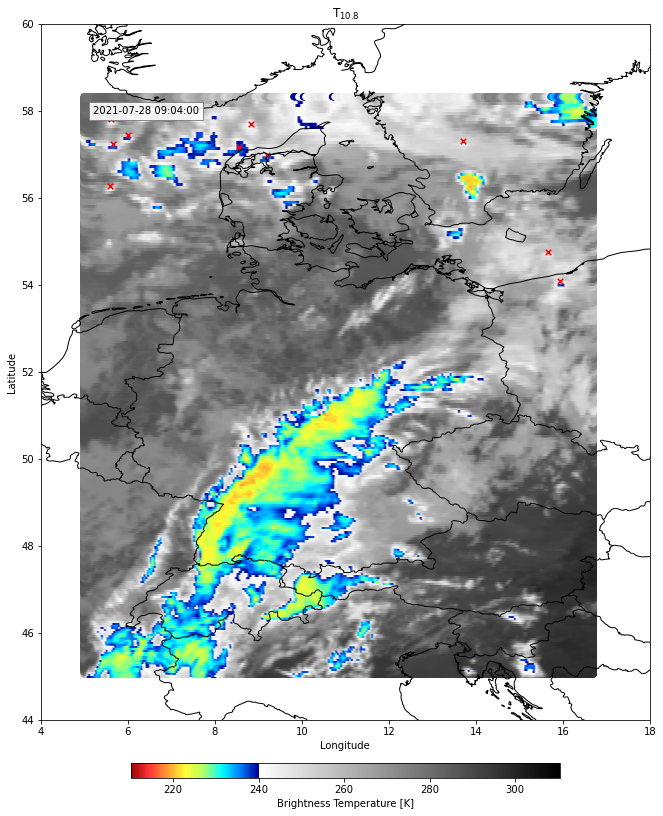

In [30]:
# Get OLR data
olr = pd.DataFrame({'olr':OLR[i].flatten()})
index = pd.MultiIndex.from_product([lat, lon], names = ["lat", "lon"])
cells = pd.DataFrame(index = index).reset_index()
cells = pd.concat([cells, olr], axis = 1)

# Define colorbar
col_temp = LinearSegmentedColormap.from_list('my_list',colors=['black','white'])
newcolors = col_temp(np.linspace(0,1,400))

col_binary = LinearSegmentedColormap.from_list('my_list',colors=['white','black'])
bincolors = col_binary(np.linspace(0,1,280))
newcolors[120:400,:] = bincolors

col_color = LinearSegmentedColormap.from_list('my_list',colors=['#990000','#FF3333','#FF9933','#FFFF33','#B2FF66','#00FFFF','#0080FF','#000099'])
colors = col_color(np.linspace(0,1,120))
newcolors[0:120,:] = colors

newcmp = ListedColormap(newcolors)

points = data[data.timestr == str(pd.to_datetime(time_olr[i],unit='s'))]
points = points[['latitude','longitude']]

plt.figure(figsize=(11,16))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([cells.lon.min(), cells.lon.max(), cells.lat.min(), cells.lat.max()])
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.scatter(x = cells.lon, y = cells.lat, c = cells.olr, cmap=newcmp, vmin = 210, vmax = 310.5)
cbar = plt.colorbar(orientation="horizontal", pad = 0.05, shrink = 0.7, aspect = 30)
cbar.set_label('Brightness Temperature [K]', rotation=0)
plt.scatter(x = points.longitude, y = points.latitude, c = 'red', s = 30, marker='x')
plt.title('T$_{10.8}$')
t = plt.text(cells.lon.min()+0.2,cells.lat.max()-0.4,pd.to_datetime(time_olr[i],unit='s'))
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='grey'))

In [31]:
# CREATE A GIF
# filepaths
fp_in = "/Volumes/Elements/gifs/pics/olr_*.png"
fp_out = "/Volumes/Elements/gifs/pics/"+"OLR_"+y_oi+"_"+m_oi+"_"+d_oi+".gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)